In [1]:
%cd /content/drive/MyDrive/AI_Course/Module_02/94_PT_TextRetrievalProject
!ls

/content/drive/MyDrive/AI_Course/Module_02/94_PT_TextRetrievalProject
'230714 - M02PT03 - Text Retrieval Project - TA_Thang'
'230714 - Text Retrieval Project - TA_Thang.zip'
 __MACOSX
 TextRetrievalWithBERT.ipynb
 TextRetrievalWithBOW.ipynb


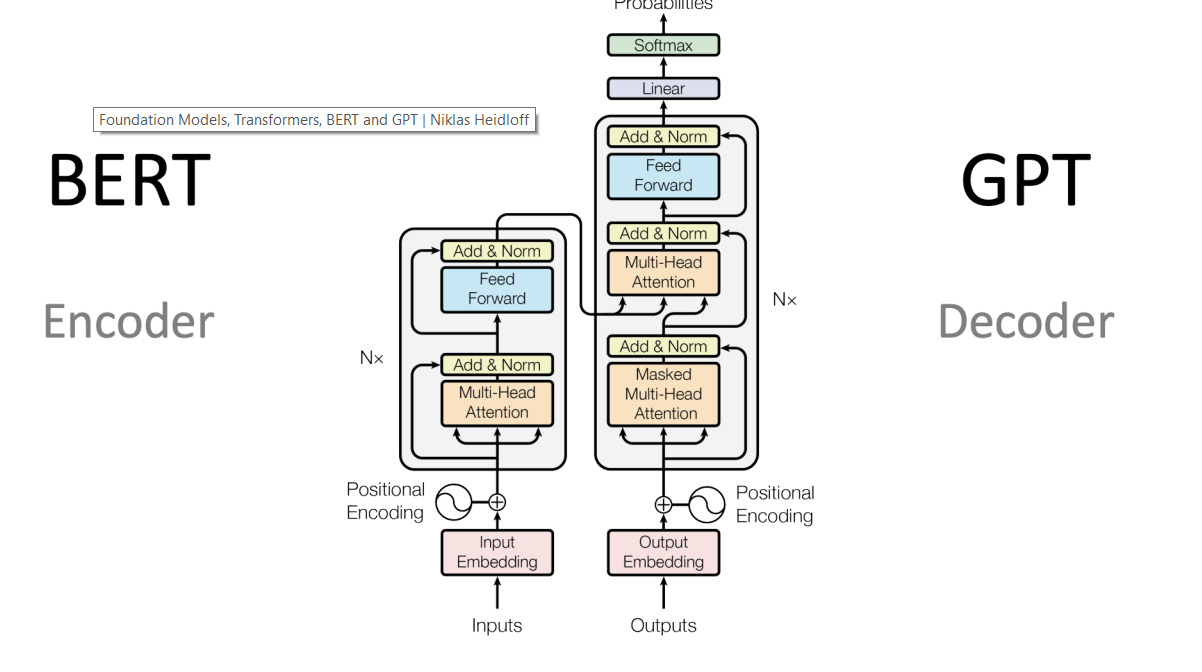

#Semantic Search Pipeline
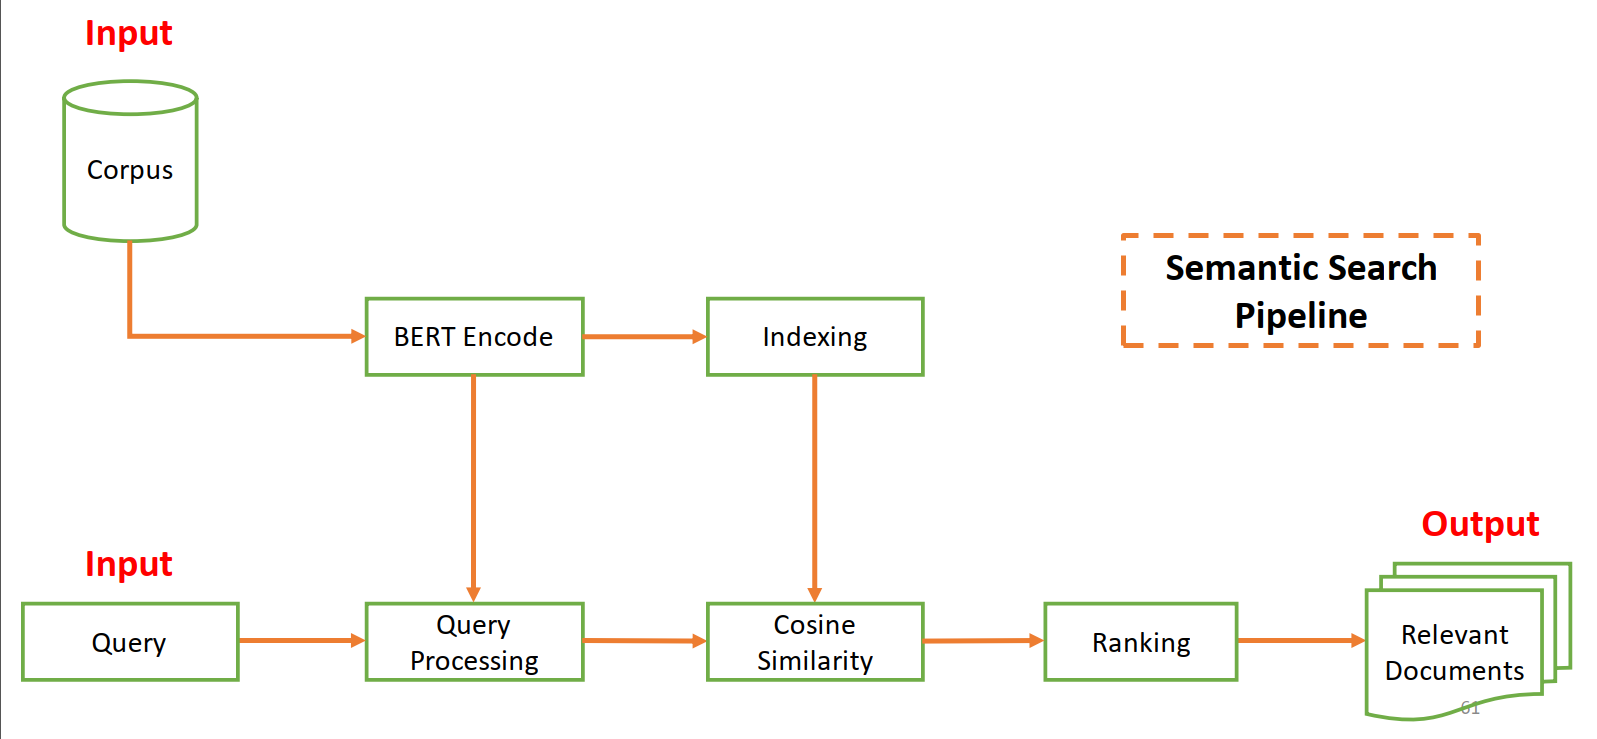

In [2]:
! pip install datasets==2.13.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 10.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 9.8 MB/s eta 0:00:00


In [3]:
from datasets import load_dataset
dataset = load_dataset('ms_marco', 'v1.1')
print(dataset)
subset = dataset['test']

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating validation split:   0%|          | 0/10047 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/82326 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/9650 [00:00<?, ? examples/s]

Dataset ms_marco downloaded and prepared to /root/.cache/huggingface/datasets/ms_marco/v1.1/1.1.0/b6a62715fa5219aea5275dd3556601004cd63945cb63e36e022f77bb3cbbca84. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    validation: Dataset({
        features: ['answers', 'passages', 'query', 'query_id', 'query_type', 'wellFormedAnswers'],
        num_rows: 10047
    })
    train: Dataset({
        features: ['answers', 'passages', 'query', 'query_id', 'query_type', 'wellFormedAnswers'],
        num_rows: 82326
    })
    test: Dataset({
        features: ['answers', 'passages', 'query', 'query_id', 'query_type', 'wellFormedAnswers'],
        num_rows: 9650
    })
})


In [4]:
queries_infos = []
queries = []
corpus = []

In [5]:
for sample in subset :
  query_type = sample ['query_type']
  # only get sample of query_type = entity
  if query_type != 'entity':
    continue
  query_id  = sample['query_id']
  query_str = sample['query']
  passages_dict = sample['passages']
  is_selected_lst = passages_dict['is_selected']
  passage_text_lst = passages_dict['passage_text']
  query_info ={
      'query_id': query_id,
      'query'   : query_str,
      'relevant_docs' : []
  }

  current_len_corpus = len(corpus)
  for idx in range(len(is_selected_lst)):
    if is_selected_lst[idx] == 1 :
      doc_idx = current_len_corpus + idx
      query_info['relevant_docs'].append(doc_idx)
  if query_info ['relevant_docs'] == []:
    continue

  queries.append(query_str)
  queries_infos.append(query_info)
  corpus += passage_text_lst
  # print('corpus',corpus)
print(len(queries))
print(len(queries_infos))
print(len(corpus))

878
878
7303


In [6]:
!pip show torch

Name: torch
Version: 2.0.1+cu118
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, jinja2, networkx, sympy, triton, typing-extensions
Required-by: fastai, torchaudio, torchdata, torchtext, torchvision, triton


In [7]:
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.4 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=3f3a1053a5ba77e981a177c337fe664cabb3dcc989da85f00371f16bf894ccf6
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [8]:
import torch
from sentence_transformers import SentenceTransformer

In [9]:
model = SentenceTransformer('all-MiniLM-L6-v2')
corpus_embeddings = model.encode(corpus,convert_to_tensor=True)

In [10]:
from sentence_transformers import util

In [11]:
def similarity(query_embeddings, corpus_embeddings):
  return util.cos_sim(query_embeddings,corpus_embeddings)

In [12]:
def ranking(query,top_k=10):
  query_embeddings = model.encode(
      query,
      convert_to_tensor=True
  )
  cos_scores = similarity(
      query_embeddings,
      corpus_embeddings
  )
  top_results = torch.topk(cos_scores, k =top_k)
  return top_results


In [65]:
custom_queries = ['what is the official language in Fiji ']
top_k = min(5,len(corpus))
for query in custom_queries:
  top_results = ranking(query,top_k)
  # x=  top_results[0].to('cpu')
  # y=  top_results[0].to('cpu')
  # print(top_results[0][0][1])
  # print(top_results[1][0][1])
  # print(abc)
  # print(top_results[1])
  print('Query:',query)
  print('\n==================')
  print(f'Top {top_k} most similar sentences in corpus:\n')

  for idx, (score, doc_idx) in enumerate(
      zip( top_results[0][0], top_results[1][0])
  ):
    print(f'Document rank {idx+1}:')
    print(corpus[doc_idx],f'\n(Score: {score} )','\n')


Query: what is the official language in Fiji 

Top 5 most similar sentences in corpus:

Document rank 1:
The official languages. Fiji’s 1997 Constitution established Fijian as one of the official languages of the country. Fijian is an Austronesian language, a grouping that includes thousands of other languages spanning the globe. The language is of the Malayo-Polynesian family, not too different from Hawaiian and Maori. 
(Score: 0.8663357496261597 ) 

Document rank 2:
Fiji has three official languages under the 1997 constitution (and not revoked by the 2013 Constitution): English, Fijian and Hindi. Fijian is spoken either as a first or second language by indigenous Fijians who make up around 54% of the population. 
(Score: 0.846449077129364 ) 

Document rank 3:
The Republic of the Fiji Islands citizens speak British English. Fijian and Fiji-Hindi is the second language. Other major language that is taught in elementary/primary schools and high schools are Urdu and French. Urdu and Fren